In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%run util_draw.py
# #### included in util_draw.py ...
# from matplotlib import rc
# rc('text', usetex=True)
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# import matplotlib.gridspec as gridspec
# import rootpy.plotting.root2matplotlib as rplt
# import ROOT as R
# ####

import json
import rootpy as rpy
from rootpy.io import root_open
from rootpy.plotting import Hist, Hist2D, Hist3D, HistStack
from array import array
from ROOT import gROOT
import math

dir_data = '/home/ephelps/projects/phys-ana-omega/e1f6/test'
fn_data = 'e1f_sample60_skim_small.root'
fn_out = 'e1f_posfid.root'
# fn_data = 'e16_sample60_skim_small.root'
# fn_out = 'e16_posfid.root'

# def rh1(drawstr, cutstr='', hn='htemp', N=None, binning=None):
#     with root_open('%s/%s'%(dir_data, fn_data)) as fin:
#         h10 = fin.get(tpath)
#         drawstr = '%s>>%s' % (drawstr, hn)
#         if binning is not None:
#             drawstr += str(binning)
#         print(drawstr)
#         print(cutstr)
#         print(type(h10))
#         h10.draw(drawstr, cutstr, 'goff', N if N is not None else h10.GetEntriesFast())
#         return asrootpy(gROOT.FindObject(hn))

r2d = math.degrees(1)

def twos_comp(val):
    if (val & (1 << 7)) != 0:
        val = val - (1 << 8)
    return val

# Positive hadrons

## Get experimental ang-p hists

In [2]:
# h3s = [Hist3D(90, 0, 90, 60, -30, 30, 40, 0, 4,
#               name='hpang_pos_s%d'%sect,
#               title='hpang_pos_s%d'%sect) for sect in range(1,7)]
# fn_data = 'e16_sample60_skim_small.root'
# fn_out = 'e16_posfid.root'
h3s = []
h3s_sim = []
with root_open('%s/%s'%(dir_data, fn_data)) as fin:
    tpath = 'h10_eid_efid_nphe_mmp/h10'
    h10 = fin.get(tpath)
    for sect in range(1,7):
        hn = 'hpang_pos_s%d'%sect
#         binning = '90, 0, 90, 60, -30, 30, 40, 0, 4'
        binning = '40, 0, 4, 60, -30, 30, 90, 0, 90'
        drawstr = 'p:%f*atan2(cy,cx)-(sc_sect[sc-1]-1)*60+((%f*atan2(cy,cx)<-30)*360):%f*acos(cz)>>%s(%s)'%(r2d,r2d,r2d,hn,binning)
        selstr = '1*q==1 && sc>0 && dc>0 && sc_sect[sc-1]==%d && dc_sect[dc-1]==%d'%(sect,sect)
        h10.Draw(drawstr, selstr)
        h3 = asrootpy(gROOT.FindObject(hn))
        h3s.append(h3)
        h3.SetDirectory(0)
        

## Get simulation ang-p hists

In [12]:
with root_open('%s/%s'%(dir_data, 'e1f_sim_h10sample.root')) as fin:
    tpath = 'h10'
    h10 = fin.get(tpath)
    for sect in range(1,7):
        hn = 'hpang_pos_s%d_sim'%sect
#         binning = '90, 0, 90, 60, -30, 30, 40, 0, 4'
        binning = '40, 0, 4, 60, -30, 30, 90, 0, 90'
        drawstr = 'p:%f*atan2(cy,cx)-(sc_sect[sc-1]-1)*60+((%f*atan2(cy,cx)<-30)*360):%f*acos(cz)>>%s(%s)'%(r2d,r2d,r2d,hn,binning)
        selstr = '1*q==1 && sc>0 && dc>0 && sc_sect[sc-1]==%d && dc_sect[dc-1]==%d'%(sect,sect)
        h10.Draw(drawstr, selstr)
        h3 = asrootpy(gROOT.FindObject(hn))
        h3s_sim.append(h3)
        h3.SetDirectory(0)

In [1]:
def get_h3p(sector, mom_l, mom_h=None, is_sim=False):
    h3 = h3s[sector-1] if not is_sim else h3s_sim[sector-1]
    b1 = h3.GetXaxis().FindBin(mom_l)
    b2 = b1 if mom_h is None else h3.GetXaxis().FindBin(mom_h)
    h3.GetXaxis().SetRange(b1,b2)
    h2 = asrootpy(h3.Project3D('yz'))
    h3.GetXaxis().SetRange(0,0)
    return h2.Clone()

.


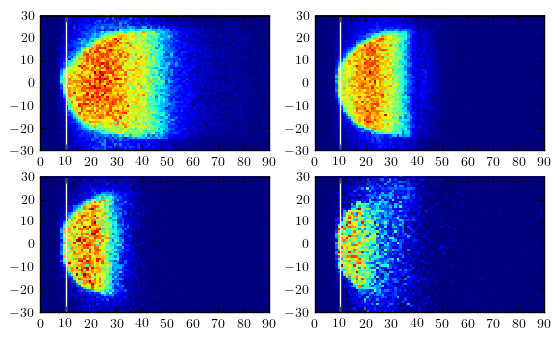

In [15]:
fig = mdraw([get_h3p(3,0,1),
             get_h3p(3,1,2),
             get_h3p(3,2,3),
             get_h3p(3,3,4)], 2, 2)
for ax in fig.get_axes():
    ax.vlines(10,-30,30, 'w')
print('.')

In [4]:
def get_tgraph(X, Y):
    g = R.TGraph(len(X), array('d', X), array('d', Y))
    return g

ps = list(np.arange(0.15, 2.55, 0.1))
f1 = R.TF1('f1', '[0]*(1-TMath::Exp([1]*(x-[2])))', 0, 90)
# f1.SetParLimits(0, 20, 30)
f1.FixParameter(0, 24)
# f1.SetParLimits(1, -1, -0.1)
f1.FixParameter(1, -0.18) #-0.22)
# f1.SetParLimits(2, 2, 10)
f1.FixParameter(2, 6)
h2s = [get_h3p(1,p0,p0, is_sim=False) for p0 in ps]
h2s_boundaries = []
h2s_boundary_parms = []
for h2 in h2s:
    h2.Rebin2D(2,2)
    [low_points, high_points] = get_plateau_edges_2d(h2, loose=0.5, window=4, ylow=5, yhigh=40, transpose=True)
    Ylo,Xlo = zip(*low_points)
    Ylo = [-y for y in Ylo]
    Yhi,Xhi = zip(*high_points)
    X = Xlo + Xhi
    Y = list(Ylo) + list(Yhi)
    g = get_tgraph(X, Y)
    fitres = g.Fit(f1, 'S')
    parms = list([f1.GetParameter(i) for i in range(0,3)])
    h2s_boundaries.append([low_points,high_points])
    h2s_boundary_parms.append(parms)

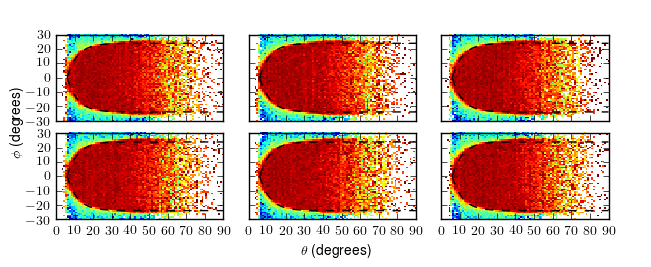

In [14]:
yoffset = 0 #[0.5, 0.3, 0.3, 0, 0, 0]
tight = 0 #1
parms = [24, -0.18, 6] #e1f
# parms = [24, -0.14, 6] #e16
f1.SetParameters(array('d', parms))
fig = sdraw([norm_x_slices(get_h3p(sect, 0.5, 4, is_sim=False) for sect in range(1,7)],
                    xlabel=r'$\theta$ (degrees)',
                    ylabel=r'$\phi$ (degrees)',
                    xlims=(0, 90), ylims=(-30, 30), space=0.15,
                    norm=LogNorm())
# fig = sdraw([get_h3p(sect, 0.5, 4) for sect in range(1,7)],
#                     xlabel=r'$\theta$ (degrees)',
#                     ylabel=r'$\phi$ (degrees)',
#                     xlims=(0, 90), ylims=(-30, 30), space=0.15)
points = get_points_from_TF1(f1,parms[2],90)
X,Y = list(zip(*points))
for iax, ax in enumerate(fig.get_axes()[0:6]):
    ax.plot(X,[y+yoffset-tight for y in Y], 'k-', linestyle='dashed')
    ax.plot(X,[-y+yoffset+tight for y in Y], 'k-', linestyle='dashed')
#     ax.plot(X,[y+yoffset[iax]-tight for y in Y], 'k-', linestyle='dashed')
#     ax.plot(X,[-y+yoffset[iax]+tight for y in Y], 'k-', linestyle='dashed')
plt.show()
fig.savefig('posfid_sectors_e1f.pdf')
# fig.savefig('posfid_sectors_e16.pdf')

.


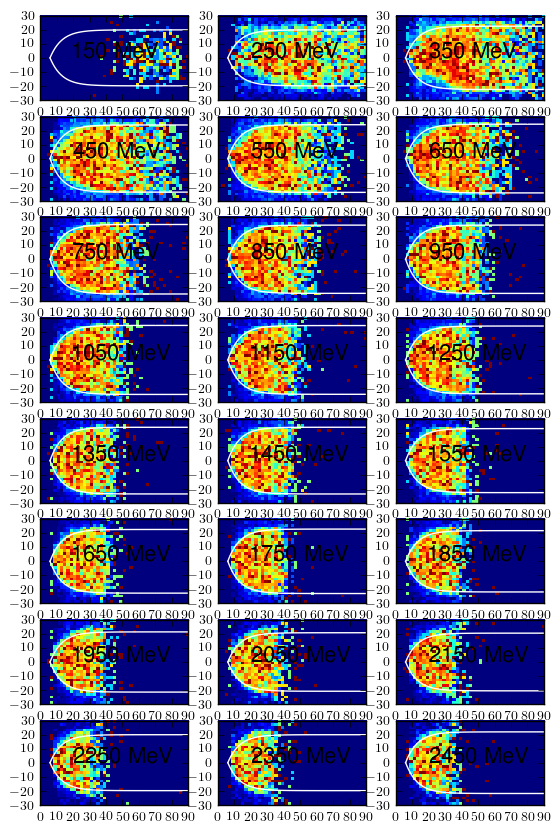

In [31]:
fig = mdraw([norm_x_slices(h2) for h2 in h2s], 3, 8)
for i,ax in enumerate(fig.get_axes()):
    [low_points, high_points] = h2s_boundaries[i]
#     Y,X = zip(*low_points)
#     ax.plot(X,Y, 'ko', fillstyle='none')
#     Y,X = zip(*high_points)
#     ax.plot(X,Y, 'ko', fillstyle='none')
    parms = list(h2s_boundary_parms[i])
    for iparm,parm in enumerate(parms):
        f1.SetParameter(iparm,parm)
    points = get_points_from_TF1(f1,parms[2],90)
    X,Y = list(zip(*points))
    ax.plot(X,[y+yoffset-tight for y in Y],'w-')
    ax.plot(X,[-y+yoffset+tight for y in Y], 'w-')
    ax.text(20, 0, '%d MeV'%(ps[i]*1000), color='k', fontsize=16)
    # ax.vlines(10,-30,30, 'w')
print('.')

In [10]:
def get_tgraph(X, Y):
    g = R.TGraph(len(X), array('d', X), array('d', Y))
    return g

ps = list(np.arange(0.15, 2.55, 0.1))
f1 = R.TF1('f1', '[0]*(1-TMath::Exp([1]*(x-[2])))', 0, 90)
# f1.SetParLimits(0, 20, 30)
f1.FixParameter(0, 25)
# f1.SetParLimits(1, -1, -0.1)
f1.FixParameter(1, -0.22)
# f1.SetParLimits(2, 2, 10)
f1.FixParameter(2, 6)
h2s = [get_h3p(1,p0,p0, is_sim=True) for p0 in ps]
h2s_boundaries = []
h2s_boundary_parms = []
for h2 in h2s:
    h2.Rebin2D(2,2)
    [low_points, high_points] = get_plateau_edges_2d(h2, loose=0.5, window=2, ylow=5, yhigh=40, transpose=True)
    Ylo,Xlo = zip(*low_points)
    Ylo = [-y for y in Ylo]
    Yhi,Xhi = zip(*high_points)
    X = Xlo + Xhi
    Y = list(Ylo) + list(Yhi)
    g = get_tgraph(X, Y)
    fitres = g.Fit(f1, 'S')
    parms = list([f1.GetParameter(i) for i in range(0,3)])
    h2s_boundaries.append([low_points,high_points])
    h2s_boundary_parms.append(parms)

.


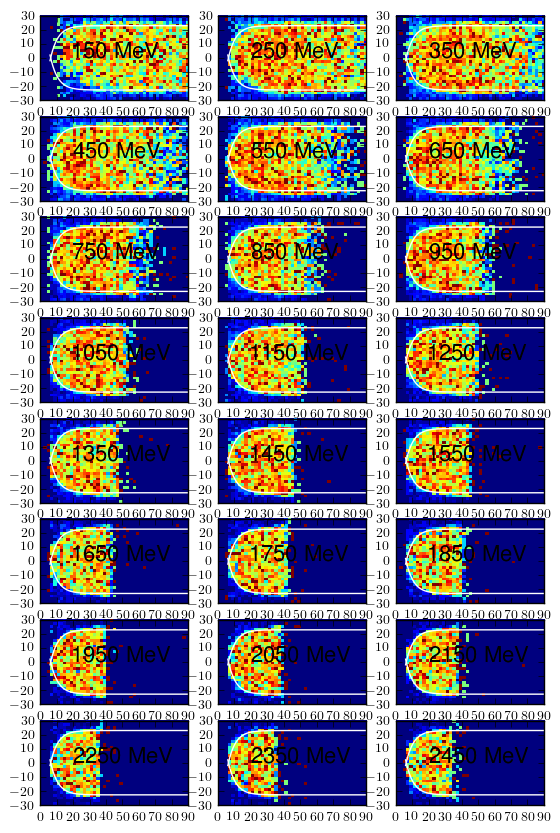

In [11]:
yoffset = 0
tight = 2
fig = mdraw([norm_x_slices(h2) for h2 in h2s], 3, 8)
for i,ax in enumerate(fig.get_axes()):
    [low_points, high_points] = h2s_boundaries[i]
#     Y,X = zip(*low_points)
#     ax.plot(X,Y, 'ko', fillstyle='none')
#     Y,X = zip(*high_points)
#     ax.plot(X,Y, 'ko', fillstyle='none')
    parms = list(h2s_boundary_parms[i])
    for iparm,parm in enumerate(parms):
        f1.SetParameter(iparm,parm)
    points = get_points_from_TF1(f1,parms[2],90)
    X,Y = list(zip(*points))
    ax.plot(X,[y+yoffset-tight for y in Y],'w-')
    ax.plot(X,[-y+yoffset+tight for y in Y], 'w-')
    ax.text(20, 0, '%d MeV'%(ps[i]*1000), color='k', fontsize=16)
    # ax.vlines(10,-30,30, 'w')
print('.')

In [32]:
[F, b, t0] = list(zip(*h2s_boundary_parms))

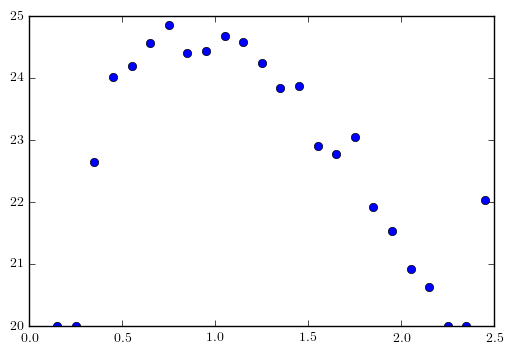

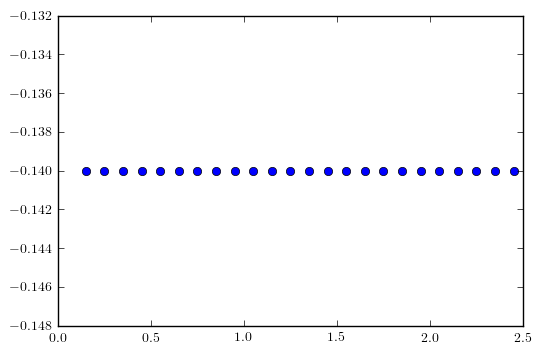

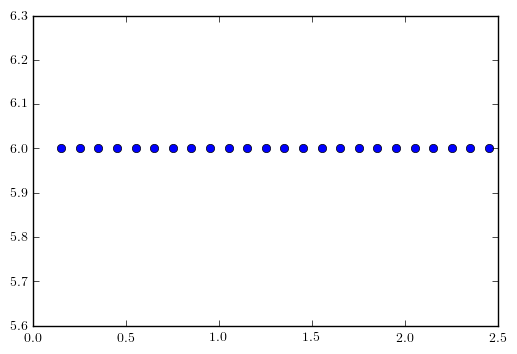

In [33]:
plt.plot(ps,F,'o')
plt.show()
plt.plot(ps,b,'o')
plt.show()
plt.plot(ps,t0,'o')
plt.show()

In [51]:
hp_p, hp_pip = None, None
hthVp_p, hthVp_pip = None, None
hp_p_sim, hp_pip_sim = None, None
hthVp_p_sim, hthVp_pip_sim = None, None
with root_open('%s/%s'%(dir_data, fn_data)) as fin:
    tpath = 'h10_eid_efid_nphe_mmp/h10'
    drawstr = 'p:%f*acos(cz)>>hthVp_pos(400,0,4,360,0,90)'%r2d
    print(drawstr)
    fin.get(tpath).Draw(drawstr, '1*q==1 && 1*stat>0 && sc>0 && dc>0', 'colz')
    hthVp_pos = asrootpy(gROOT.FindObject('hthVp_pos'))
    drawstr = 'p:%f*acos(cz)>>hthVp_p(400,0,4,360,0,90)'%r2d
    print(drawstr)
    fin.get(tpath).Draw(drawstr, 'id==2212 && 1*stat>0 && sc>0 && dc>0', 'colz')
    hthVp_p = asrootpy(gROOT.FindObject('hthVp_p'))
    drawstr = 'p:%f*acos(cz)>>hthVp_pip(400,0,4,360,0,90)'%r2d
    print(drawstr)
    fin.get(tpath).Draw(drawstr, 'id==211 && 1*stat>0 && sc>0 && dc>0', 'colz')
    hthVp_pip = asrootpy(gROOT.FindObject('hthVp_pip'))
    hp_p = asrootpy(hthVp_p.ProjectionX('hp_p'))
    hp_pip = asrootpy(hthVp_pip.ProjectionX('hp_pip'))
    for h in [hthVp_p, hthVp_pip, hp_p, hp_pip]:
        print(type(h))
        h.SetDirectory(0)

with root_open('%s/%s'%(dir_data, 'e1f_sim_h10sample.root')) as fin:
    tpath = 'h10'
    drawstr = 'p:%f*acos(cz)>>hthVp_pos_sim(400,0,4,360,0,90)'%r2d
    print(drawstr)
    fin.get(tpath).Draw(drawstr, '1*q==1 && 1*stat>0 && sc>0 && dc>0', 'colz')
    hthVp_pos_sim = asrootpy(gROOT.FindObject('hthVp_pos_sim'))
    drawstr = 'p:%f*acos(cz)>>hthVp_p_sim(400,0,4,360,0,90)'%r2d
    print(drawstr)
    fin.get(tpath).Draw(drawstr, 'id==2212 && 1*stat>0 && sc>0 && dc>0', 'colz')
    hthVp_p_sim = asrootpy(gROOT.FindObject('hthVp_p_sim'))
    drawstr = 'p:%f*acos(cz)>>hthVp_pip_sim(400,0,4,360,0,90)'%r2d
    print(drawstr)
    fin.get(tpath).Draw(drawstr, 'id==211 && 1*stat>0 && sc>0 && dc>0', 'colz')
    hthVp_pip_sim = asrootpy(gROOT.FindObject('hthVp_pip_sim'))
    hp_p_sim = asrootpy(hthVp_p_sim.ProjectionX('hp_p_sim'))
    hp_pip_sim = asrootpy(hthVp_pip_sim.ProjectionX('hp_pip_sim'))
    for h in [hthVp_p_sim, hthVp_pip_sim, hp_p_sim, hp_pip_sim]:
        print(type(h))
        h.SetDirectory(0)
#     h10 = fin.h10_eid_efid_nphe_mmp.h10
#     hp_p = rh1('p',
#                'id==2212', 'hp_p',
#                binning='(600,0,6)')
#     hp_pip = rh1('p',
#                  'id==211', 'hp_pip',
#                  binning='(600,0,6)')

p:57.295780*acos(cz)>>hthVp_pos(400,0,4,360,0,90)
p:57.295780*acos(cz)>>hthVp_p(400,0,4,360,0,90)
p:57.295780*acos(cz)>>hthVp_pip(400,0,4,360,0,90)
<class 'rootpy.plotting.hist._Hist2D_class.<locals>.Hist2D'>
<class 'rootpy.plotting.hist._Hist2D_class.<locals>.Hist2D'>
<class 'rootpy.plotting.hist._Hist_class.<locals>.Hist'>
<class 'rootpy.plotting.hist._Hist_class.<locals>.Hist'>
p:57.295780*acos(cz)>>hthVp_pos_sim(400,0,4,360,0,90)
p:57.295780*acos(cz)>>hthVp_p_sim(400,0,4,360,0,90)
p:57.295780*acos(cz)>>hthVp_pip_sim(400,0,4,360,0,90)
<class 'rootpy.plotting.hist._Hist2D_class.<locals>.Hist2D'>
<class 'rootpy.plotting.hist._Hist2D_class.<locals>.Hist2D'>
<class 'rootpy.plotting.hist._Hist_class.<locals>.Hist'>
<class 'rootpy.plotting.hist._Hist_class.<locals>.Hist'>


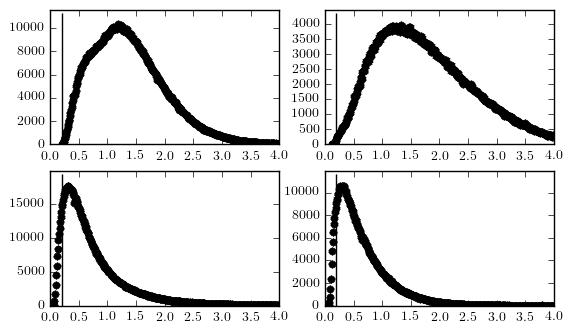

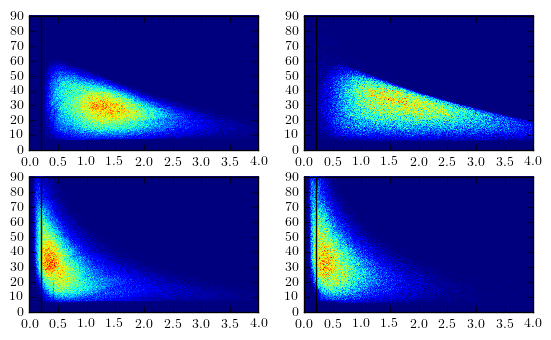

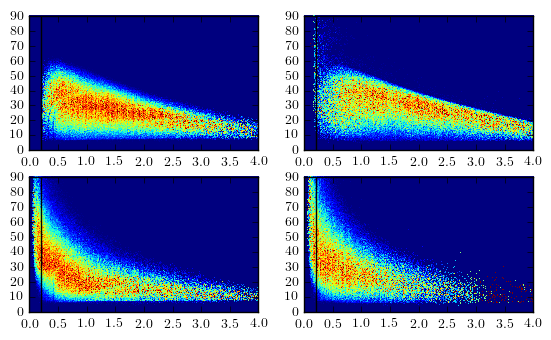

In [54]:
hps = [hp_p, hp_p_sim, hp_pip, hp_pip_sim]
fig = mdraw(hps, 2, 2)
for ax,hp in zip(fig.get_axes(),hps):
    ax.vlines(0.2, 0, hp.GetMaximum()*1.1)
plt.show()
fig2 = mdraw([hthVp_p, hthVp_p_sim, hthVp_pip, hthVp_pip_sim], 2, 2)
for ax in fig2.get_axes():
    ax.vlines(0.2, 0, 90)
plt.show()
fig3 = mdraw([norm_x_slices(hthVp_p), norm_x_slices(hthVp_p_sim), norm_x_slices(hthVp_pip), norm_x_slices(hthVp_pip_sim)], 2, 2)
for ax in fig3.get_axes():
    ax.vlines(0.2, 0, 90)
plt.show()

In [55]:
for h2 in [hthVp_p, hthVp_pip, hthVp_p_sim, hthVp_pip_sim, hthVp_pos, hthVp_pos_sim]:
    h2.Rebin2D(8,8)
    h2.scale(1.0/h2.Integral())

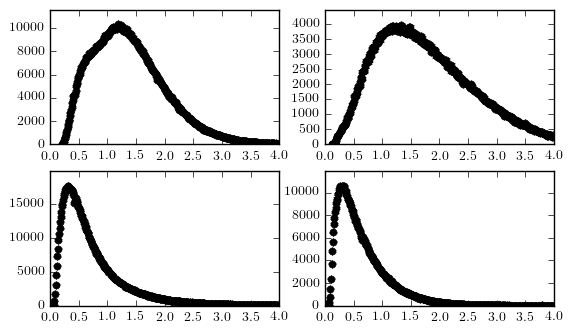

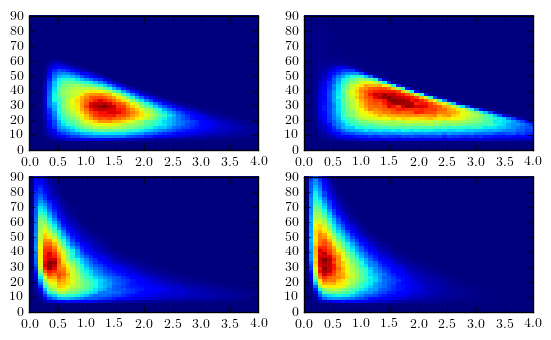

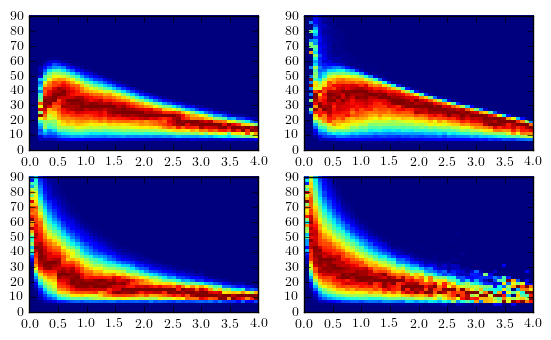

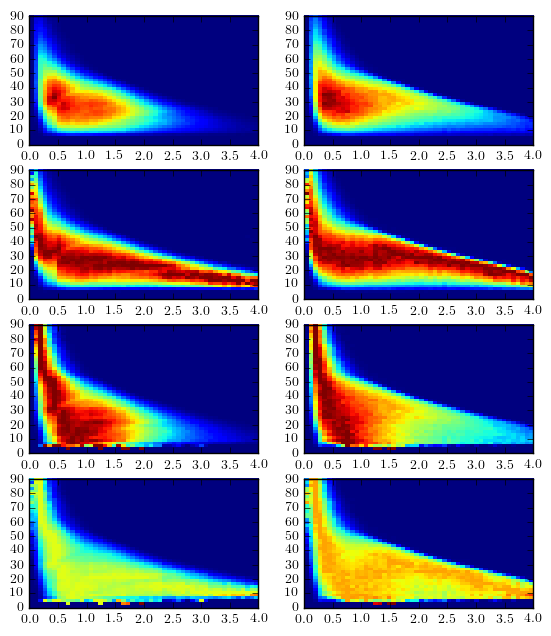

In [57]:
mdraw([hp_p, hp_p_sim, hp_pip, hp_pip_sim], 2, 2)
plt.show()
mdraw([hthVp_p, hthVp_p_sim, hthVp_pip, hthVp_pip_sim], 2, 2)
plt.show()
mdraw([norm_x_slices(hthVp_p), norm_x_slices(hthVp_p_sim), norm_x_slices(hthVp_pip), norm_x_slices(hthVp_pip_sim)], 2, 2)
plt.show()
mdraw([hthVp_pos, hthVp_pos_sim,
       norm_x_slices(hthVp_pos), norm_x_slices(hthVp_pos_sim),
       norm_y_slices(hthVp_pos), norm_y_slices(hthVp_pos_sim),
       norm_x_slices(norm_y_slices(hthVp_pos),(10,90)),
       norm_x_slices(norm_y_slices(hthVp_pos_sim),(10,90))], 2, 4)
plt.show()

In [7]:
hnnsim = norm_x_slices(norm_y_slices(hthVp_pos_sim),(10,90))
hnnexp = norm_x_slices(norm_y_slices(hthVp_pos),(10,90))
hnnsim_p = norm_x_slices(norm_y_slices(hthVp_p_sim),(10,90))
hnnexp_p = norm_x_slices(norm_y_slices(hthVp_p),(10,90))
hnnsim_pip = norm_x_slices(norm_y_slices(hthVp_pip_sim),(10,90))
hnnexp_pip = norm_x_slices(norm_y_slices(hthVp_pip),(10,90))
# hnnsim = norm_x_slices(norm_y_slices(hthVp_pos_sim,(0.2,4)),(10,90))
# hnnexp = norm_x_slices(norm_y_slices(hthVp_pos,(0.2,4)),(10,90))
# hnnsim_p = norm_x_slices(norm_y_slices(hthVp_p_sim,(0.5,4)),(10,90))
# hnnexp_p = norm_x_slices(norm_y_slices(hthVp_p,(0.5,4)),(10,90))
# hnnsim_pip = norm_x_slices(norm_y_slices(hthVp_pip_sim,(0.2,4)),(10,90))
# hnnexp_pip = norm_x_slices(norm_y_slices(hthVp_pip,(0.2,4)),(10,90))

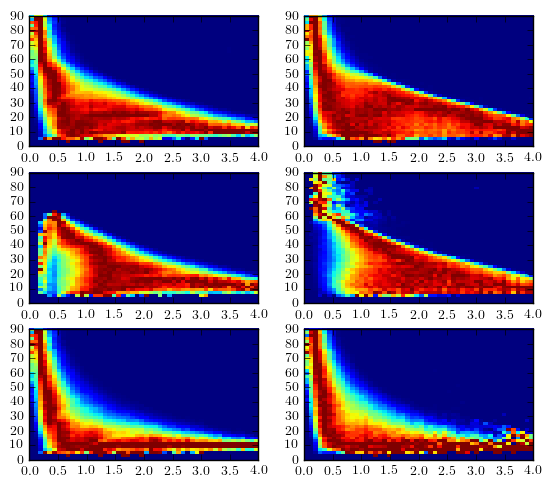

In [8]:
hs = [hnnexp,hnnsim, hnnexp_p, hnnsim_p, hnnexp_pip, hnnsim_pip]
fig = mdraw(hs, 2, 3)
axs = fig.get_axes()
for ax,h in zip(axs,hs):
    rplt.imshow(h, axes=ax, vmax=1)

In [8]:
hthVp_pip_eDs = hthVp_pip.clone('hthVp_pip_eDs')
hthVp_pip_eDs.Divide(hthVp_pip_sim)

True

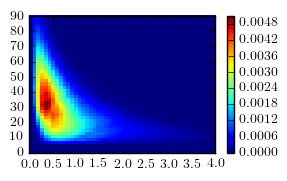

In [7]:
fig = draw(hthVp_pip) #, norm=LogNorm())
im = rplt.imshow(hthVp_pip, colorbar=True) #, norm=LogNorm())
# fig.colorbar(im, )

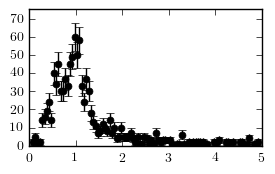

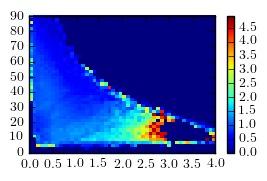

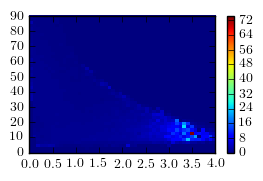

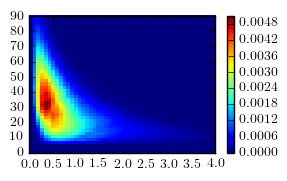

In [15]:
hd = Hist(100, 0, 5)
hthVp_pip_eDs_0s = hthVp_pip_eDs.clone('hthVp_pip_eDs_0s')
for i,b in enumerate(hthVp_pip_eDs):
    if b.value > 0: hd.Fill(b.value)
    if b.value > 0.25 and b.value < 5:
        hthVp_pip_eDs_0s.set_bin_content(i, b.value)
    else:
        hthVp_pip_eDs_0s.set_bin_content(i, 0)
draw(hd)
# plt.xlim(0,5)
# plt.ylim(0,1000)
fig = draw(hthVp_pip_eDs_0s) #, norm=LogNorm())
im = rplt.imshow(hthVp_pip_eDs_0s, colorbar=True) #, norm=LogNorm())
plt.show()
hthVp_pip_eDs.set_maximum(5)
fig2 = draw(hthVp_pip_eDs) #, norm=LogNorm())
im = rplt.imshow(hthVp_pip_eDs, colorbar=True) #, norm=LogNorm())
plt.show()
fig3 = draw(hthVp_pip) #, norm=LogNorm())
im = rplt.imshow(hthVp_pip, colorbar=True) #, norm=LogNorm())
plt.show()

.


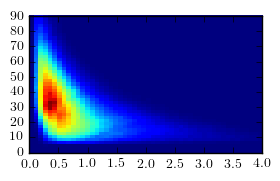

In [9]:
draw(hthVp_pip)
print('.')

In [10]:
htnhVp_pip_0s = hthVp_pip.clone('hthVp_pip_0s')

In [63]:
lo,hi,e = get_yedges_2d(hthVp_pos, 0.9)

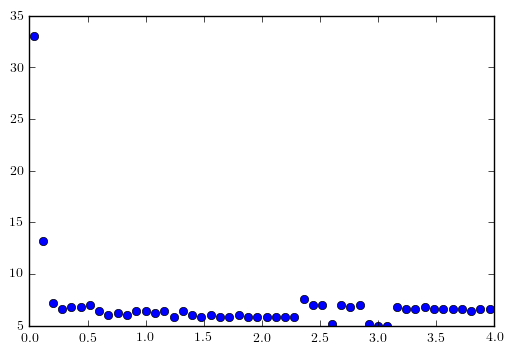

In [73]:
[X,Y] = list(zip(*lo))
plt.plot(X,Y, 'o')

# Negative hadrons

## Get experimental ang-p hists

In [2]:
# h3s = [Hist3D(90, 0, 90, 60, -30, 30, 40, 0, 4,
#               name='hpang_pos_s%d'%sect,
#               title='hpang_pos_s%d'%sect) for sect in range(1,7)]
# fn_data = 'e16_sample60_skim_small.root'
# fn_out = 'e16_posfid.root'
h3s = []
h3s_sim = []
with root_open('%s/%s'%(dir_data, fn_data)) as fin:
    tpath = 'h10_eid_efid_nphe_mmp/h10'
    h10 = fin.get(tpath)
    for sect in range(1,7):
        hn = 'hpang_neg_s%d'%sect
#         binning = '90, 0, 90, 60, -30, 30, 40, 0, 4'
        binning = '40, 0, 4, 60, -30, 30, 90, 0, 90'
        drawstr = 'p:%f*atan2(cy,cx)-(sc_sect[sc-1]-1)*60+((%f*atan2(cy,cx)<-30)*360):%f*acos(cz)>>%s(%s)'%(r2d,r2d,r2d,hn,binning)
        selstr = '1*id!=11 && 1*q==-1 && sc>0 && dc>0 && sc_sect[sc-1]==%d && dc_sect[dc-1]==%d'%(sect,sect)
        h10.Draw(drawstr, selstr)
        h3 = asrootpy(gROOT.FindObject(hn))
        h3s.append(h3)
        h3.SetDirectory(0)
        

## Get simulation ang-p hists

In [12]:
with root_open('%s/%s'%(dir_data, 'e1f_sim_h10sample.root')) as fin:
    tpath = 'h10'
    h10 = fin.get(tpath)
    for sect in range(1,7):
        hn = 'hpang_pos_s%d_sim'%sect
#         binning = '90, 0, 90, 60, -30, 30, 40, 0, 4'
        binning = '40, 0, 4, 60, -30, 30, 90, 0, 90'
        drawstr = 'p:%f*atan2(cy,cx)-(sc_sect[sc-1]-1)*60+((%f*atan2(cy,cx)<-30)*360):%f*acos(cz)>>%s(%s)'%(r2d,r2d,r2d,hn,binning)
        selstr = '1*q==1 && sc>0 && dc>0 && sc_sect[sc-1]==%d && dc_sect[dc-1]==%d'%(sect,sect)
        h10.Draw(drawstr, selstr)
        h3 = asrootpy(gROOT.FindObject(hn))
        h3s_sim.append(h3)
        h3.SetDirectory(0)

In [3]:
def get_h3p(sector, mom_l, mom_h=None, is_sim=False):
    h3 = h3s[sector-1] if not is_sim else h3s_sim[sector-1]
    b1 = h3.GetXaxis().FindBin(mom_l)
    b2 = b1 if mom_h is None else h3.GetXaxis().FindBin(mom_h)
    h3.GetXaxis().SetRange(b1,b2)
    h2 = asrootpy(h3.Project3D('yz'))
    h3.GetXaxis().SetRange(0,0)
    return h2.Clone()

.


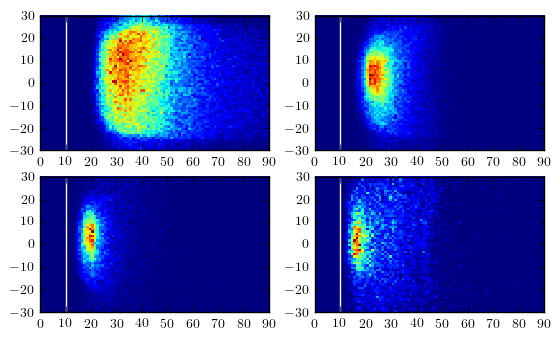

In [5]:
fig = mdraw([get_h3p(1,0,1),
             get_h3p(1,1,2),
             get_h3p(1,2,3),
             get_h3p(1,3,4)], 2, 2)
for ax in fig.get_axes():
    ax.vlines(10,-30,30, 'w')
print('.')

In [4]:
def get_tgraph(X, Y):
    g = R.TGraph(len(X), array('d', X), array('d', Y))
    return g

ps = list(np.arange(0.15, 2.55, 0.1))
f1 = R.TF1('f1', '[0]*(1-TMath::Exp([1]*(x-[2])))', 0, 90)
# f1.SetParLimits(0, 20, 30)
f1.FixParameter(0, 24)
# f1.SetParLimits(1, -1, -0.1)
f1.FixParameter(1, -0.18) #-0.22)
# f1.SetParLimits(2, 2, 10)
f1.FixParameter(2, 6)
h2s = [get_h3p(1,p0,p0, is_sim=False) for p0 in ps]
h2s_boundaries = []
h2s_boundary_parms = []
for h2 in h2s:
    h2.Rebin2D(2,2)
    [low_points, high_points] = get_plateau_edges_2d(h2, loose=0.5, window=4, ylow=5, yhigh=40, transpose=True)
    Ylo,Xlo = zip(*low_points)
    Ylo = [-y for y in Ylo]
    Yhi,Xhi = zip(*high_points)
    X = Xlo + Xhi
    Y = list(Ylo) + list(Yhi)
    g = get_tgraph(X, Y)
    fitres = g.Fit(f1, 'S')
    parms = list([f1.GetParameter(i) for i in range(0,3)])
    h2s_boundaries.append([low_points,high_points])
    h2s_boundary_parms.append(parms)

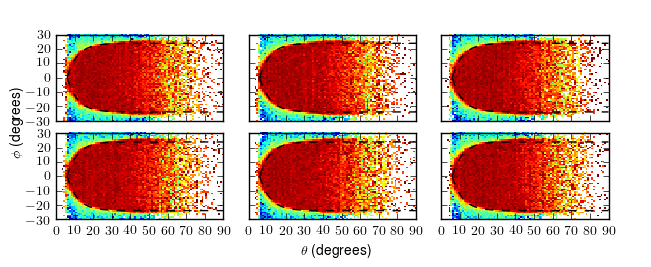

In [14]:
yoffset = 0 #[0.5, 0.3, 0.3, 0, 0, 0]
tight = 0 #1
parms = [24, -0.18, 6] #e1f
# parms = [24, -0.14, 6] #e16
f1.SetParameters(array('d', parms))
fig = sdraw([norm_x_slices(get_h3p(sect, 0.5, 4, is_sim=False) for sect in range(1,7)],
                    xlabel=r'$\theta$ (degrees)',
                    ylabel=r'$\phi$ (degrees)',
                    xlims=(0, 90), ylims=(-30, 30), space=0.15,
                    norm=LogNorm())
# fig = sdraw([get_h3p(sect, 0.5, 4) for sect in range(1,7)],
#                     xlabel=r'$\theta$ (degrees)',
#                     ylabel=r'$\phi$ (degrees)',
#                     xlims=(0, 90), ylims=(-30, 30), space=0.15)
points = get_points_from_TF1(f1,parms[2],90)
X,Y = list(zip(*points))
for iax, ax in enumerate(fig.get_axes()[0:6]):
    ax.plot(X,[y+yoffset-tight for y in Y], 'k-', linestyle='dashed')
    ax.plot(X,[-y+yoffset+tight for y in Y], 'k-', linestyle='dashed')
#     ax.plot(X,[y+yoffset[iax]-tight for y in Y], 'k-', linestyle='dashed')
#     ax.plot(X,[-y+yoffset[iax]+tight for y in Y], 'k-', linestyle='dashed')
plt.show()
fig.savefig('posfid_sectors_e1f.pdf')
# fig.savefig('posfid_sectors_e16.pdf')